In [23]:
from nilearn.glm.second_level import SecondLevelModel
from nilearn.plotting import plot_design_matrix, plot_glass_brain, plot_img_on_surf
from nilearn.image import load_img, index_img
from delphi import mni_template
from glob import glob
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [2]:
class_labels = sorted(["handright", "handleft", "footleft", "footright", "tongue"])
n_classes = len(class_labels)

brain_mask = load_img(mni_template)

# original t-maps
t_maps_path = []
for i in range(len(class_labels)):
    t_maps_path.extend(glob(f"/Users/phisei/Documents/phd/thesis_code_and_analyses/t-maps/test/{class_labels[i]}/*nii.gz"))
t_maps = load_img(t_maps_path)

n_subjects = 20
n_samples = len(t_maps_path)

# lrp maps
lrp_maps_path = glob("./example_models/example_fcn3d/lrp-maps/*.nii.gz")
lrp_maps = load_img(lrp_maps_path)

In [3]:
# setup the design matrix
design_matrix = {}
# subjects
for i in range(n_subjects):
    design_matrix[f"sub{i:02d}"] = np.tile(np.eye(20)[i], 5)
    
# contrasts
for i in range(n_classes):
    design_matrix[class_labels[i]] = np.repeat(np.eye(n_classes)[i], n_subjects) 
    
# add the intercept
design_matrix["intercept"] = [1] * n_samples

df_design_matrix = pd.DataFrame(design_matrix)

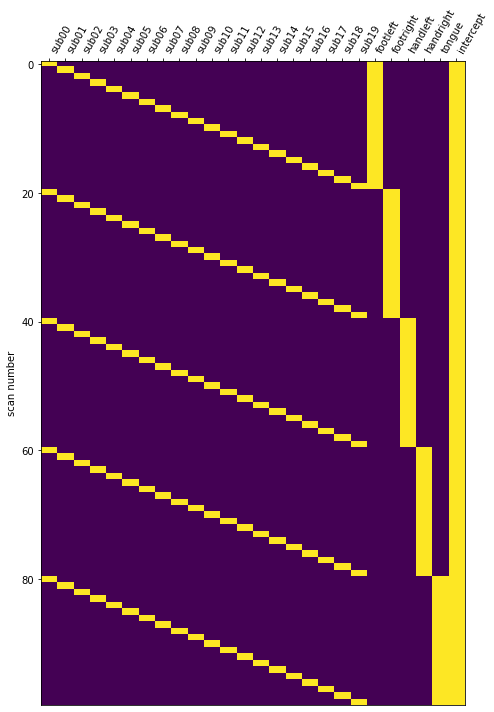

In [4]:
# show us the design matrix
plot_design_matrix(pd.DataFrame(df_design_matrix), rescale=False);

In [25]:
# Set up the SecondLevelModel
images = [index_img(t_maps, i) for i in range(n_samples)]
glm_t = SecondLevelModel(mask_img=brain_mask, smoothing_fwhm=None).fit(
    images, 
    design_matrix=df_design_matrix
)

images = [index_img(lrp_maps, i) for i in range(n_samples)]
glm_lrp = SecondLevelModel(mask_img=brain_mask, smoothing_fwhm=None).fit(
    images, 
    design_matrix=df_design_matrix
)

/Users/phisei/opt/anaconda3/envs/delphi/lib/python3.8/site-packages/nilearn/_utils/glm.py:335: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(X <= 0, 0, 1. / X)


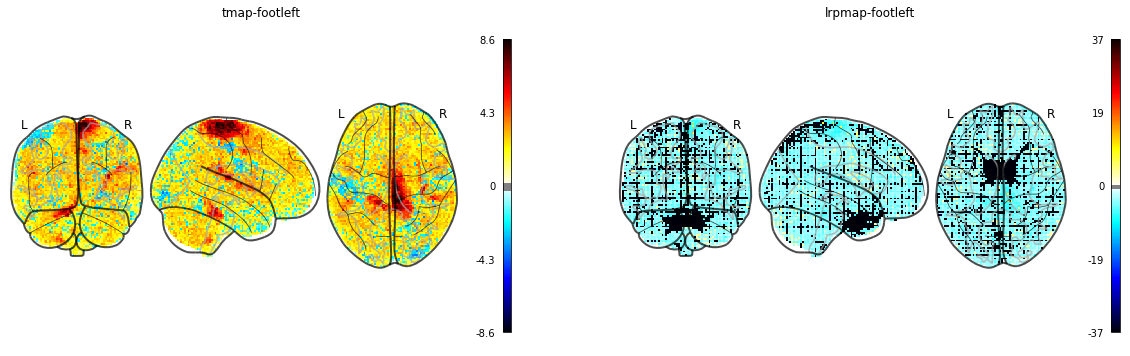

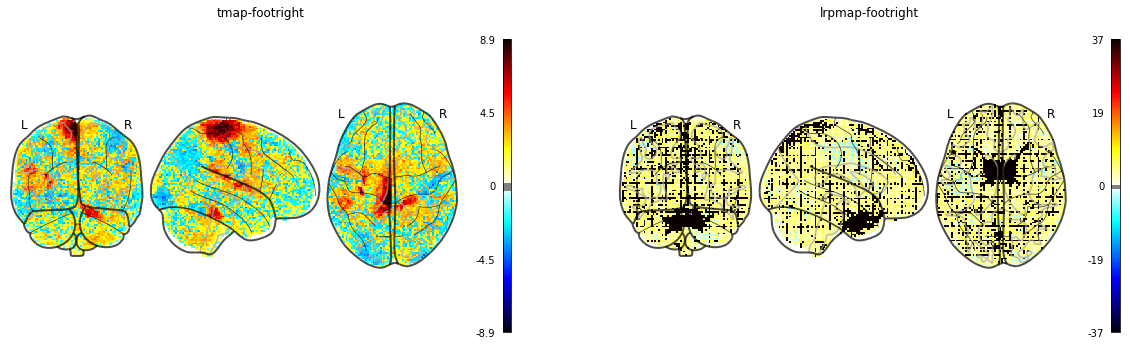

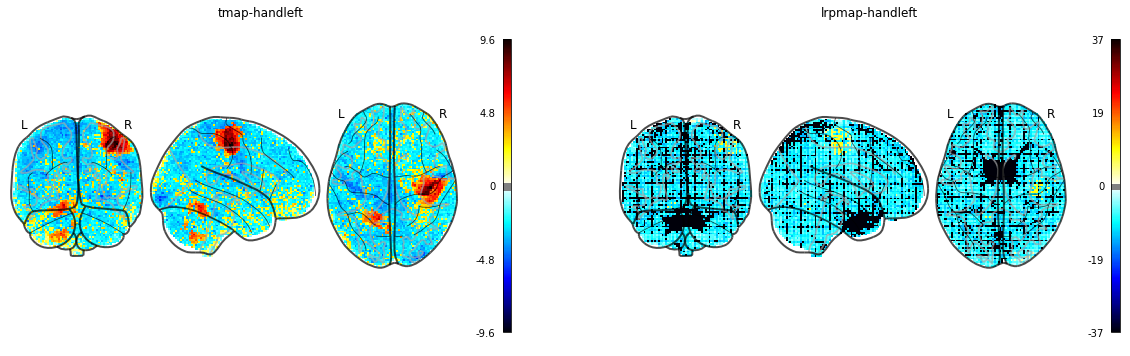

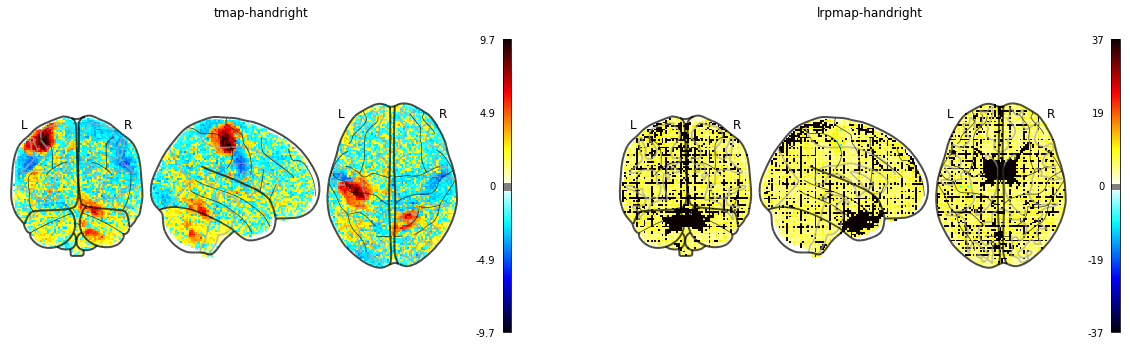

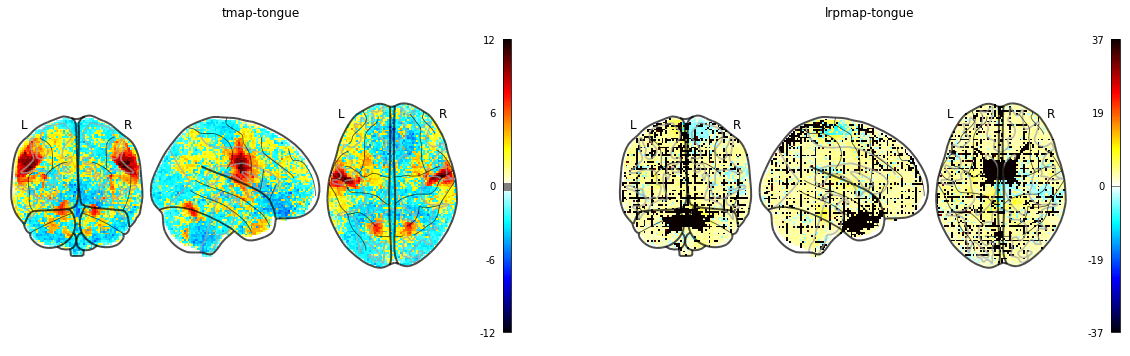

In [26]:
for i, label in enumerate(class_labels):
    out_tmaps = glm_t.compute_contrast(label, output_type="all")
    out_lrpmaps = glm_lrp.compute_contrast(label, output_type="all")
    
    fig, axes = plt.subplots(1,2,figsize=(20, 6))
    plot_glass_brain(out_tmaps["z_score"], plot_abs=False, colorbar=True, axes=axes[0]);
    axes[0].set_title(f"tmap-{label}")
    plot_glass_brain(out_lrpmaps["z_score"], plot_abs=False, colorbar=True, axes=axes[1]);
    axes[1].set_title(f"lrpmap-{label}")